**Q. What is Normalization Flow?**

Ans. "A normalizing flow describes the transformation of a probability density through a sequence of invertible mappings." - arXiv:1505.05770

> Finite Normalizing Flows: The transformation of probability densities is induced through an invertible, smooth mapping
$$f: \mathbb{R}^d \to \mathbb{R}^d$$
with an inverse $f^{-1}=g$. Therefore $z = g \circ f(z)$.
>
>
> Let us start with an element $z$, sampled from distribution $q(z)$. Applying map $f$ on $z$ results on a new variables $z' = f(z)$ with distribution
$$q(z') = q(z) \Big|\det \frac{\partial f}{\partial z} \Big|^{-1}.$$
A complex distribution can be constructed by sampling $z_0$ from a simple distribution $q_0(z_0)$ and sequentially applying several invertible, smooth maps $f_1, \cdots , f_k$ such that
$$z_k = f_k \circ \cdots \circ f_2 \circ f_1(z_0), \\
\ln q_k(z_k) = \ln q_0(z_0) - \sum_{i=1}^{k} \ln \Big|\det \frac{\partial f_i}{\partial z_{i-1}} \Big|.$$
The path traversed by variables $z_i = f_i(z_{i-1})$ is the flow.

----


One can design a Neural Network architecture with $L$ hidden layers, such that each hidden layer acts a smooth, invertible map $f_{i} \forall i \in \{1, \cdots , L \}$, and the network output $z_L = f_L \circ \cdots f_1(z_0)$ is a finite flow based on initial input distribitution $q_0(z_0)$. The output distribution given by
$$\ln q_{L}(z_L) = \ln q_0(z_0) - \sum_{i=1}^{L} \ln \Big|\det \frac{\partial f_i}{\partial z_{i-1}} \Big|.$$
Training updates network parameters $\theta$, implicit in $q_L$, to approximate a target distribution $p^*(z_L)$.


---

**Example 0: Let use create a toy target distribution and initialize a neural network to sample from a 2d Gaussian distribution.**

---

* Import packages

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import sklearn.datasets as datasets
import numpy as np

* Use "make_moons" from sklearn.datasets to create target distribution. Or, feel free to choose some other target distribution.

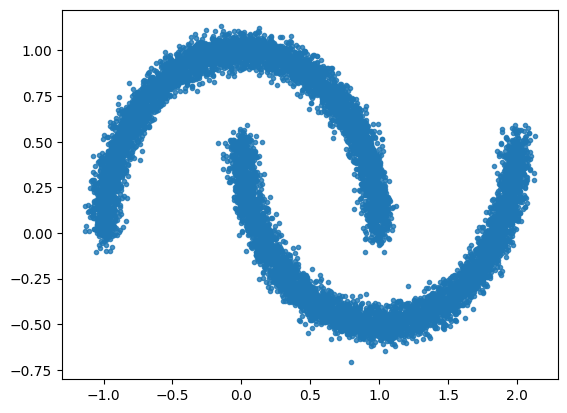

In [ ]:
moon_n = 10000
data, _ = datasets.make_moons(moon_n, noise=0.05)

plt.plot(data[:, 0], data[:, 1], ".", alpha=0.8)

* Let us use Tensorflow Keras to create a Neural Network for our normalizing flow. We will sample from a 2D Gaussian distribution to initialize. Note that if you increase the number of hidden layers, the network performance improves significantly.

In [ ]:
ndim = 2 # dimension of Gaussian distribution we will sample from
L = 2 # number of hidden layers
f_i_set = [] # we will create a set of the invertible maps

# call more functions
tfd = tfp.distributions
tfb = tfp.bijectors

z0 = tfd.MultivariateNormalDiag(loc=[0.0] * ndim)


# create a complex function "f = f_L * ... * f_1" by appending each simple map f_i
for i in range(L):
    f_i = tfb.AutoregressiveNetwork(
        params=ndim, hidden_units=[200, 200], activation="relu"
    ) # make a masked autoregressive flow first
    f_i = tfb.MaskedAutoregressiveFlow(f_i)
    f_i_set.append(f_i) # append each map to the list, iteratively
    permute_elements = tfb.Permute([1, 0])
    f_i_set.append(permute_elements)
f = tfb.Chain(f_i_set) # create one complex function using tfb.Chain

* Next, we use this complex function that we constructed, to transform the original distribution into something different. Effectively, this is the output of the initialized network.

In [ ]:
z_L_init = tfd.TransformedDistribution(z0, bijector=f)

* Let's plot the transformed probability density for a new set of inputs, for a sanity check.

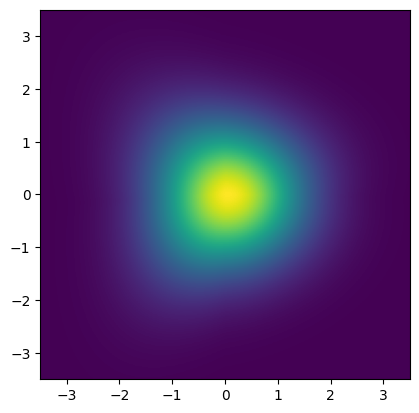

In [ ]:
new_z0 = np.linspace(-3.5, 3.5, 200)
(new_z0_1, new_z0_2) = np.meshgrid(new_z0, new_z0)
new_z0_grid = np.concatenate((new_z0_1.reshape(-1, 1), new_z0_2.reshape(-1, 1)), axis=1)
p_z_L_init = np.exp(z_L_init.log_prob(new_z0_grid)) #np.exp(ln(z_k))=z_k, the pdf of the initialized network is plotted
fig = plt.figure()
plt.imshow(p_z_L_init.reshape(new_z0_1.shape), aspect="equal", extent=[-3.5, 3.5, -3.5, 3.5])
plt.show()



----

Q. **Now that we have a Neural Network for Normalizing Flow, how do we train it?**

Define a (forward) Kullback-Leibler divergence loss function
$$D_{KL}\big(p^*(x)||q_{L}(x)\big) = - ~\mathbb{E}_{p^*}\big[\log\big(q_{L}(x)\big)\big]  + \mathbb{E}_{p^*}\big[\log\big(p^*(x)\big)\big] .$$
Training does not updated the last term, and one can redefine the loss function as
$$Loss = - ~\mathbb{E}_{p^*}\big[\log\big(q_{L}(x)\big)\big] = -~ \frac{1}{p} \sum_{i=1}^{p} \log \big(q_{L}(x_i)\big) .$$
All we need to do is maximize the network likelihood under observed samples of the target distribution.

---

**Problem 0: Train the network using KL divergence loss function to converge to the target distribution.**

---

*Solution to Problem 0 below.*

* First fit the input and output at initialization to obtain network parameters. Training will update these.

In [ ]:
x = tf.keras.Input(shape=(2,), dtype=tf.float32) # feature dimension
x_log_prob = z_L_init.log_prob(x) # placeholder function to store network output
normalizing_flow = tf.keras.Model(x, x_log_prob) # define the normalizing flow
#we are using the parameters theta associated with inputs sampled from the 2d Gaussian distribution

* Define KL loss to update network parameters

In [ ]:
def KL_loss(p_star, log_q_L): # loss functions in Keras always need at least two arguments: label and prediction. In our case, label will play no role.
    return -log_q_L

* Train the network. I have chosen Adam for optimizer.

In [ ]:
normalizing_flow.compile(optimizer=tf.optimizers.Adam(1e-3), loss=KL_loss)
train_result = normalizing_flow.fit(x=data, y=np.zeros(moon_n), epochs=800, verbose=0)

* Plot loss to check convergence

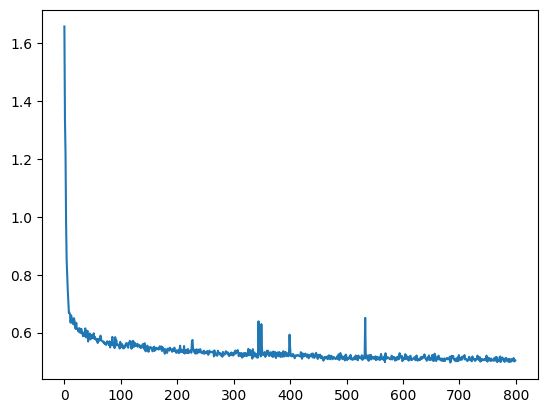

In [ ]:
plt.plot(train_result.history["loss"])
plt.show()

* Let's evaluate the probability density of the trained distribution for a new set of input points.

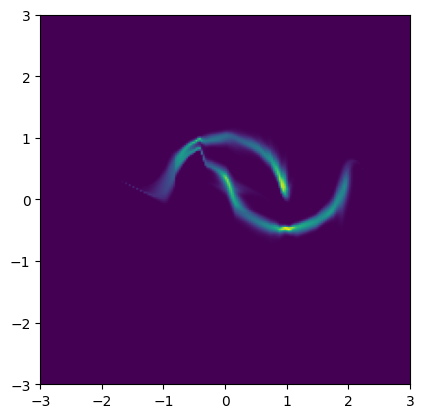

In [ ]:
z0 = np.linspace(-3, 3, 200)
(z0_1, z0_2) = np.meshgrid(z0, z0)
z0_grid = np.concatenate((z0_1.reshape(-1, 1), z0_2.reshape(-1, 1)), axis=1)
trained_p_z_L = np.exp(z_L_init.log_prob(z0_grid)) # based on updated network parameters, evaluate ln(q_L(z_L)) and invert it
fig = plt.figure()
plt.imshow(trained_p_z_L.reshape(z0_1.shape), aspect="equal", origin="lower", extent=[-3, 3, -3, 3])
plt.show()

* Lastly, let us sample some points from the trained output distribution to show it is a generative model.

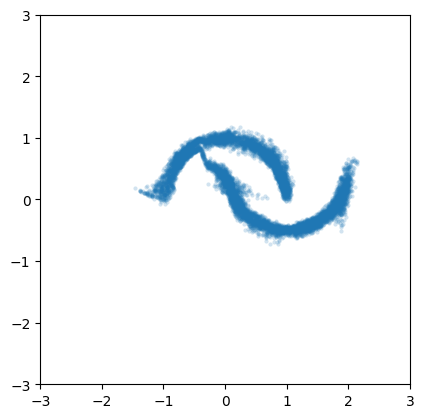

In [ ]:
samples_from_trained = z_L_init.sample(moon_n)  # let us sample points from the trained network distribution
plt.plot(samples_from_trained[:, 0], samples_from_trained[:, 1], ".", alpha=0.2, markeredgewidth=0.0)
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.gca().set_aspect("equal")

**Next up: Equivariant Neural Networks!**

----

Consider a symmetry group $G$ that has actions on two homogeneous spaces, $M_1$ and $M_2$. Let $\mathbb{T}_g$ and $\mathbb{T}'_g$ be the $G$-function transforms on the two spaces respectively, then a $G$-equivariant neural network is defined as the linear transformation $$h:f(M_1) \to f'(M_2),$$ that satisfies the following relation,
$$h\big[\mathbb{T}_g f(x)\big] = \mathbb{T}'_g h\big[f(x) \big]~ \forall~f(x).$$
When $\mathbb{T}' = \mathbb{1}$, we get $G$-invariant neural networks.

> *$G$-equivariant Convolutional Theorem: A neural network layer $h$ is $G$-equivariant if and only if it takes the form of a convolutional operator, $$h(f) = (f * \omega)(u).$$ $f: U \to \mathbb{R}^n$ and $\omega: V \to \mathbb{R}^n$ are (lifted) functions of groups $U$, $V$, subgroups of $G$.*
>
>*In this tutorial, we will consider $U=V=G.$*
>
>---
>
>In terms of irreducible representations $\rho(g)$, a $G$-equivariant convolutional neural network layer $h(g): G \to G$ becoems $$h(g) = h_0 \cdot \rho_0(g) + \vec{h}_1 \cdot \rho_1(g) + \cdots + \vec{h}_k \cdot \rho_k(g) .$$
>
>Here, $h_i$ are the weights, and $\rho_i(g)$ are irreducible represenations constructed from convolution of inputs.

---
**Example 1: Construct a SO(3) Equivariant Convolutional Neural Network Layer.**

---

Here we will use spherical harmonics $Y_{lm}$ as irreducible representations $\rho(g)$, due to the resemblance with Wigner D-matrices, one of the many possible irreps of $SO(3)$.

* Import packages.

In [ ]:
import numpy as np
from scipy.special import sph_harm

* Given input points, construct irreducible representations, for no convolutional layer. In this case, we use spherical harmonics as our basis.



In [ ]:
def irreps(x, L):
    r = np.linalg.norm(x, axis=-1) # we are transforming the basis to spherical coordinates, this one is radius.
    azimuth_angle = np.arctan2(x[:, 1], x[:, 0]) # evaluate azimuthal angle
    polar_angle = np.arccos(x[:, 2], r) # evaluate polar angle
    irreps = []
    for k in range(L):
        irreps_k = []
        for j in range(-k, k + 1):
            ii = sph_harm(j, k, azimuth_angle, polar_angle)
            irreps_k.append(ii)
        irreps_k = np.array(irreps_k)
        irreps.append(irreps_k.T)
    return irreps

* Let us print the irreducible representations for a sanity check.

In [ ]:
from tensorflow.python.ops.gen_array_ops import invert_permutation
def print_irreps(f):
    for i in range(len(f)):
        if len(f[0].shape) == 3:
            print(f"irrep {i} ({f[i].shape[-1]} channels)")
        else:
            print(f"irrep {i} (no channels)")
        print(f[i])


input = np.random.rand(2, 3)
L = 3  # number of irreps
output = irreps(input, L)
print_irreps(output)

irrep 0 (no channels)
[[0.28209479+0.j]
 [0.28209479+0.j]]
irrep 1 (no channels)
[[ 0.01514756-0.30335766j  0.23285571+0.j         -0.01514756-0.30335766j]
 [ 0.12532237-0.32152275j  0.02381728+0.j         -0.12532237-0.32152275j]]
irrep 2 (no channels)
[[-0.29705717-0.02974007j  0.01614206-0.32327429j -0.10049289+0.j
  -0.01614206-0.32327429j -0.29705717+0.02974007j]
 [-0.28370773-0.26078621j  0.01365998-0.03504557j -0.31314332+0.j
  -0.01365998-0.03504557j -0.28370773+0.26078621j]]


* Note that $l=0$ element of all outputs are equal. Next, let us design channels for convolution.

In [ ]:
def conv(r, c):
    k = np.linspace(0, 1, c)
    return np.exp(- 5 * (r - k[..., None]) ** 2 / c)

---

**Problem 1: Use the functions for irreducible representations and convolution to generate the outputs of a single $SO(3)$ equivariant CNN layer of channel size $5$, no non-linearities, and no bias.**

---

>*Solution to Problem 1 below.*

In [ ]:
def c_irreps(x, L, C):
    r = np.linalg.norm(x, axis=-1)
    rc = conv(r, C)
    azimuth_angle = np.arctan2(x[:, 1], x[:, 0])
    polar_angle = np.arccos(x[:, 2], r) # note that the radial part undergoes convolution, but computing
    irreps = []
    for j in range(L):
        irreps_j = []
        for k in range(-j, j + 1):
            ii = sph_harm(k, j, azimuth_angle, polar_angle)
            irreps_j.append(ii)
        irreps_j = np.array(irreps_j).T  # transpose so N (particles) is first axes
        irreps_j_conv = np.einsum("ij,ci->ijc", irreps_j, rc)  # outer product (all irreps with all channels)
        irreps.append(irreps_j_conv)
    return irreps


C = 5  # number of channels
output_conv = c_irreps(input, L, C)
print_irreps(output_conv)

irrep 0 (5 channels)
[[[0.14667073+0.j 0.20644992+0.j 0.25644791+0.j 0.28112328+0.j
   0.27196164+0.j]]

 [[0.18429445+0.j 0.23991062+0.j 0.27561311+0.j 0.27942384+0.j
   0.25000012+0.j]]]
irrep 1 (5 channels)
[[[ 0.00787574-0.15772602j  0.01108568-0.22201106j
    0.01377041-0.27577765j  0.01509539-0.30231292j
    0.01460344-0.29246072j]
  [ 0.12106965+0.j          0.1704145 +0.j
    0.21168545+0.j          0.23205378+0.j
    0.22449128+0.j        ]
  [-0.00787574-0.15772602j -0.01108568-0.22201106j
   -0.01377041-0.27577765j -0.01509539-0.30231292j
   -0.01460344-0.29246072j]]

 [[ 0.08187396-0.21005301j  0.10658179-0.27344256j
    0.12244284-0.31413513j  0.12413578-0.31847848j
    0.11106411-0.28494226j]
  [ 0.01555999+0.j          0.02025567+0.j
    0.02327003+0.j          0.02359177+0.j
    0.02110752+0.j        ]
  [-0.08187396-0.21005301j -0.10658179-0.27344256j
   -0.12244284-0.31413513j -0.12413578-0.31847848j
   -0.11106411-0.28494226j]]]
irrep 2 (5 channels)
[[[-0.15445018-0.

* Initialize weights of the network.

In [ ]:
W = np.random.randn(L, C, C)

* Generate outputs of this convolutional layer.

In [ ]:
for i in range(len(output_conv)):
    output_conv[i] = np.einsum("ijk,kl->ijl", output_conv[i], W[i])

print_irreps(output_conv)

irrep 0 (5 channels)
[[[-0.57396834+0.j -0.22954024+0.j  0.10086522+0.j  0.55698721+0.j
    0.35756213+0.j]]

 [[-0.58353698+0.j -0.22173592+0.j  0.13006192+0.j  0.56601927+0.j
    0.33213738+0.j]]]
irrep 1 (5 channels)
[[[ 0.00914569-0.18315928j  0.02181602-0.43690575j
    0.0330986 -0.66286008j  0.00760758-0.15235578j
   -0.01289793+0.25830472j]
  [ 0.14059209+0.j          0.33536652+0.j
    0.50880785+0.j          0.11694748+0.j
   -0.19827332+0.j        ]
  [-0.00914569-0.18315928j -0.02181602-0.43690575j
   -0.0330986 -0.66286008j -0.00760758-0.15235578j
    0.01289793+0.25830472j]]

 [[ 0.08853246-0.22713583j  0.17731114-0.45490335j
    0.29346291-0.75289831j  0.06633329-0.17018241j
   -0.10500781+0.26940443j]
  [ 0.01682543+0.j          0.03369765+0.j
    0.05577207+0.j          0.01260652+0.j
   -0.01995654+0.j        ]
  [-0.08853246-0.22713583j -0.17731114-0.45490335j
   -0.29346291-0.75289831j -0.06633329-0.17018241j
    0.10500781+0.26940443j]]]
irrep 2 (5 channels)
[[[-0.8